In [228]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from utils.elpv_reader import load_dataset

Step1:  Load the dataset

In [290]:
# Respectively: image, reflection probability, type. Our classifier needs to classify based on reflection probability
images, proba, types = load_dataset()
print(images.shape)
print(proba)
print(types)

(2624, 300, 300)
[1. 1. 1. ... 0. 0. 0.]
['mono' 'mono' 'mono' ... 'poly' 'poly' 'poly']


In [291]:
proba_1, proba_2, proba_3, proba_4 = 0, 0, 0, 0
for i in range(len(proba)):
    if proba[i] == 1.0:
        proba_1 = proba_1 + 1
    elif proba[i] == 0.6666666666666666:
        proba_2 = proba_2 + 1
    elif proba[i] == 0.3333333333333333:
        proba_3 = proba_3 + 1
    else:
        proba_4 = proba_4 + 1
print(f"The number of 0% probability images is: {proba_4}, the proportion is: {format(proba_4 / len(proba), '.2f')}")
print(f"The number of 33% probability images is: {proba_3}, the proportion is: {format(proba_3 / len(proba), '.2f')} ")
print(f"The number of 66% probability images is: {proba_2}, the proportion is: {format(proba_2 / len(proba), '.2f')} ")
print(f"The number of 100% probability images is: {proba_1}, the proportion is: {format(proba_1 / len(proba), '.2f')} ")

The number of 0% probability images is: 1508, the proportion is: 0.57
The number of 33% probability images is: 295, the proportion is: 0.11 
The number of 66% probability images is: 106, the proportion is: 0.04 
The number of 100% probability images is: 715, the proportion is: 0.27 


Step2: Split the dataset into train set and test set

In [292]:
# split the dataset into train set and test set
x_train, x_test, y_train, y_test = train_test_split(images, proba, test_size=0.25, stratify=proba, random_state=42)

In [293]:
proba_1, proba_2, proba_3, proba_4 = 0, 0, 0, 0
for i in range(len(y_train)):
    if y_train[i] == 1.0:
        proba_1 = proba_1 + 1
    elif y_train[i] == 0.6666666666666666:
        proba_2 = proba_2 + 1
    elif y_train[i] == 0.3333333333333333:
        proba_3 = proba_3 + 1
    else:
        proba_4 = proba_4 + 1
print(f"The number of 0% train images is: {proba_4}, the proportion is: {format(proba_4 / len(y_train), '.2f')}")
print(f"The number of 33% train images is: {proba_3}, the proportion is: {format(proba_3 / len(y_train), '.2f')} ")
print(f"The number of 66% train images is: {proba_2}, the proportion is: {format(proba_2 / len(y_train), '.2f')} ")
print(f"The number of 100% train images is: {proba_1}, the proportion is: {format(proba_1 / len(y_train), '.2f')} ")

The number of 0% train images is: 1131, the proportion is: 0.57
The number of 33% train images is: 221, the proportion is: 0.11 
The number of 66% train images is: 80, the proportion is: 0.04 
The number of 100% train images is: 536, the proportion is: 0.27 


In [294]:
proba_1, proba_2, proba_3, proba_4 = 0, 0, 0, 0
for i in range(len(y_test)):
    if y_test[i] == 1.0:
        proba_1 = proba_1 + 1
    elif y_test[i] == 0.6666666666666666:
        proba_2 = proba_2 + 1
    elif y_test[i] == 0.3333333333333333:
        proba_3 = proba_3 + 1
    else:
        proba_4 = proba_4 + 1
print(f"The number of 0% test images is: {proba_4}, the proportion is: {format(proba_4 / len(y_test), '.2f')}")
print(f"The number of 33% test images is: {proba_3}, the proportion is: {format(proba_3 / len(y_test), '.2f')} ")
print(f"The number of 66% test images is: {proba_2}, the proportion is: {format(proba_2 / len(y_test), '.2f')} ")
print(f"The number of 100% test images is: {proba_1}, the proportion is: {format(proba_1 / len(y_test), '.2f')} ")

The number of 0% test images is: 377, the proportion is: 0.57
The number of 33% test images is: 74, the proportion is: 0.11 
The number of 66% test images is: 26, the proportion is: 0.04 
The number of 100% test images is: 179, the proportion is: 0.27 


Step3: Convert each image to pixel histogram

In [295]:
his_train = []
his_test = []
for image in x_train:
    hist = cv2.calcHist([image], [0], None,
                        [256], [0.0, 255.0])

    his_train.append(((hist / 255).flatten()))
    
for image in x_test:
    hist = cv2.calcHist([image], [0], None,
                        [256], [0.0, 255.0])

    his_test.append(((hist / 255).flatten()))

(256,)


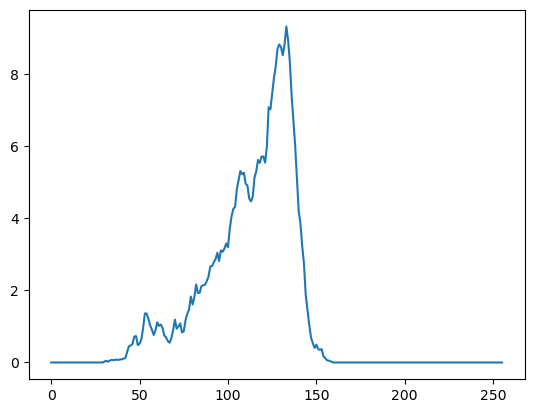

In [296]:
print(his_train[0].shape)
plt.plot(his_train[0])

Step4: Use the SVM classifier to process the dataset

In [297]:
# kernel options: ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
# when doing classifier, y_train is a vector of integers or strings
svm_classifier = SVC(kernel="linear").fit(his_train, y_train.astype("str"))
predict_labels = svm_classifier.predict(his_test)

Step5: Report the performance of SVM

In [298]:
print(metrics.classification_report(y_test.astype("str"), predict_labels))

                    precision    recall  f1-score   support

               0.0       0.65      0.90      0.75       377
0.3333333333333333       0.14      0.01      0.02        74
0.6666666666666666       0.00      0.00      0.00        26
               1.0       0.65      0.43      0.52       179

          accuracy                           0.64       656
         macro avg       0.36      0.34      0.32       656
      weighted avg       0.56      0.64      0.58       656



The predicted label of test[101] is: 0.0


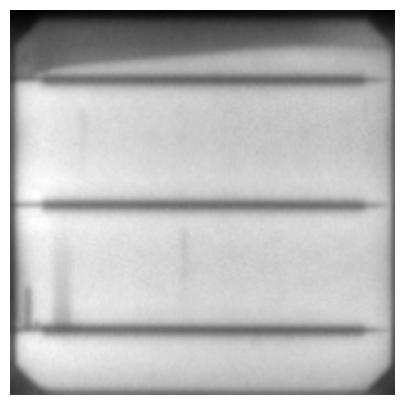

The predicted label of test[102] is: 0.0


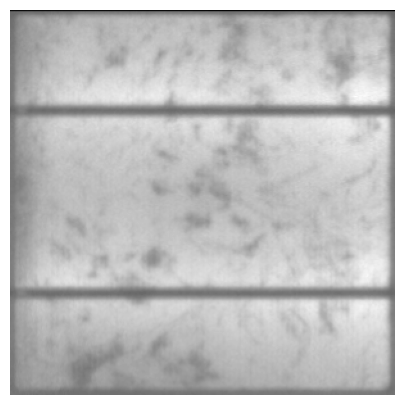

The predicted label of test[103] is: 0.0


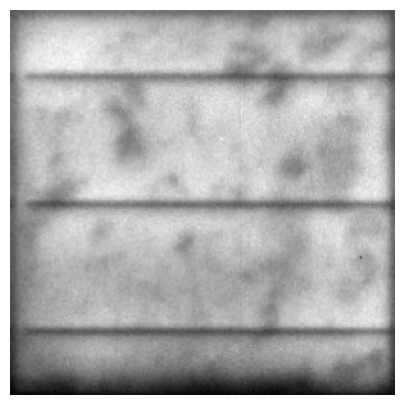

The predicted label of test[104] is: 1.0


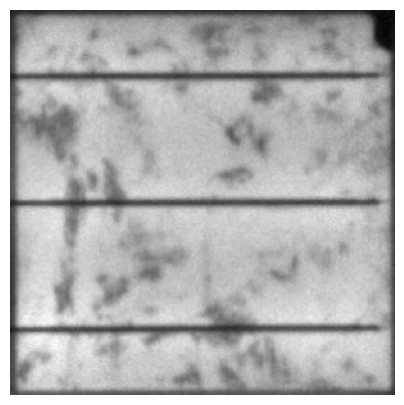

The predicted label of test[105] is: 0.0


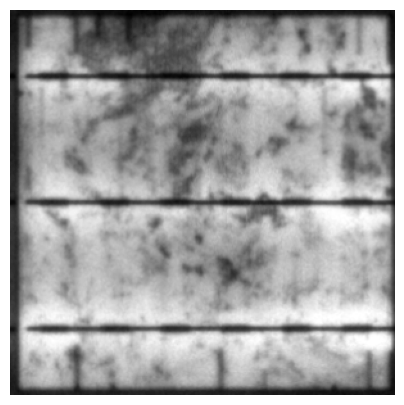

The predicted label of test[106] is: 1.0


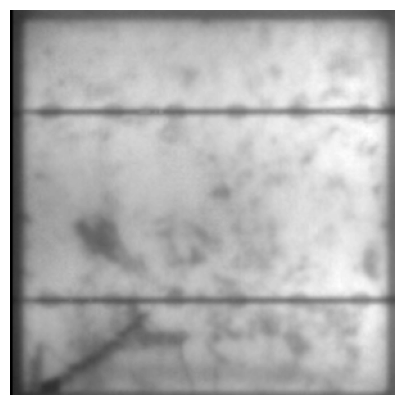

The predicted label of test[107] is: 1.0


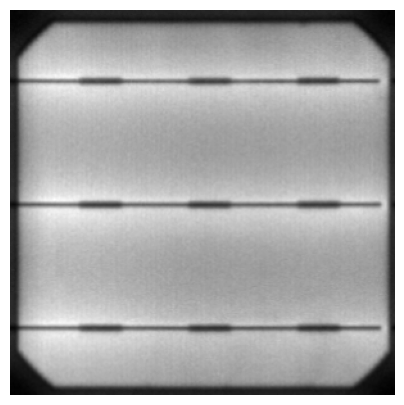

The predicted label of test[108] is: 1.0


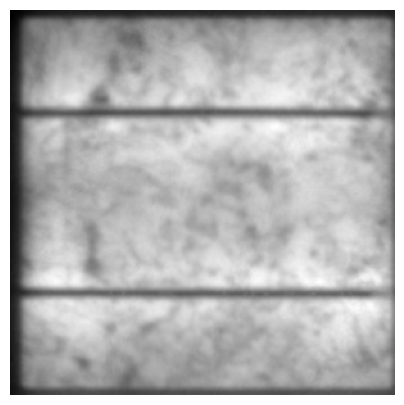

The predicted label of test[109] is: 0.0


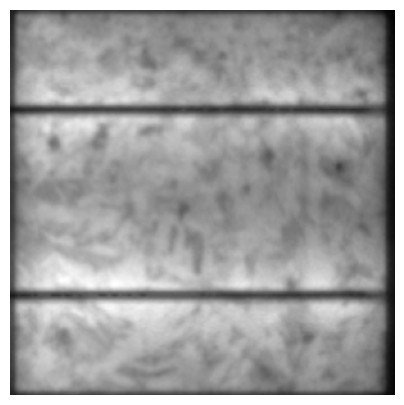

The predicted label of test[110] is: 0.0


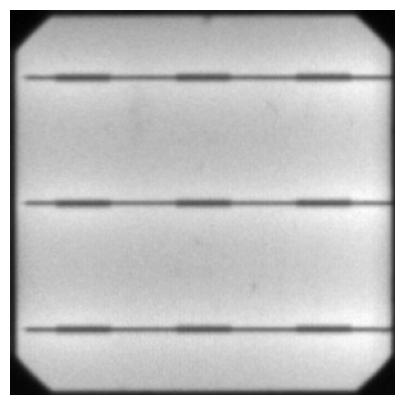

In [299]:
# show the part of test images and its prediction results
num = 10
for i in range(100, 110):
    plt.figure(figsize=(5, 5))
    plt.axis("off")
    plt.imshow(x_test[i], cmap="gray")
    print(f"The predicted label of test[{i + 1}] is: {predict_labels[i]}")
    plt.show()

# Test

In [300]:
from sklearn.metrics import confusion_matrix
import pandas as pd

### 1. Calculate the confusion matrix for all test images

In [301]:
# Calculate the confusion matrix for all test images
confusion_all = confusion_matrix(y_test.astype("str"), predict_labels)
# print(confusion_all)
confusion_all = np.array(confusion_all)

# Class label
class_labels = ["0.0", "0.3333", "0.6666", "1.0"]

# Print confusion matrix
print("Confusion Matrix (All Test Images):")
print("\t" + "\t".join(class_labels))
for i in range(len(class_labels)):
    print(class_labels[i] + "\t", end="")
    for j in range(len(class_labels)):
        print(confusion_all[i][j], end="\t")
    print()

# Calculate accuracy, recall and F1 scores
for i in range(len(class_labels)):
    tp = confusion_all[i][i]
    fp = sum(confusion_all[j][i] for j in range(len(class_labels)) if j != i)
    fn = sum(confusion_all[i][j] for j in range(len(class_labels)) if j != i)
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
    print(f"\nClass {class_labels[i]}:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")


Confusion Matrix (All Test Images):
	0.0	0.3333	0.6666	1.0
0.0	339	5	4	29	
0.3333	61	1	0	12	
0.6666	25	0	0	1	
1.0	99	1	2	77	

Class 0.0:
Precision: 0.62
Recall: 0.36
F1 Score: 0.45

Class 0.3333:
Precision: 0.62
Recall: 0.36
F1 Score: 0.45

Class 0.6666:
Precision: 0.62
Recall: 0.36
F1 Score: 0.45

Class 1.0:
Precision: 0.62
Recall: 0.36
F1 Score: 0.45


### 2.Calculate the confusion matrix for monocrystalline

In [302]:
print("y_test size:", y_test.shape)
print("predict_labels size:", predict_labels.shape)

y_test size: (656,)
predict_labels size: (656,)


In [303]:
# monocrystalline_indices range of index values
y_test = y_test.astype("str")
monocrystalline_indices = np.where(types == 'mono')
print("Monocrystalline Indices Range:", min(monocrystalline_indices[0]), "to", max(monocrystalline_indices[0]))

Monocrystalline Indices Range: 0 to 2443


In [304]:
# Prints the unique value of the types array
unique_types = np.unique(types)
print(unique_types)


['mono' 'poly']


In [305]:
# calculate monocrystalline_indices
monocrystalline_indices = np.where(types == 'mono')[0]  # Extract the index array with [0]

# Create a y_test_mono array that contains only the real labels for images of type "monocrystalline"
y_test_mono = y_test[monocrystalline_indices[monocrystalline_indices < len(y_test)]]

# Creates the predict_labels_mono array that contains only prediction labels for images of type "monocrystalline"
predict_labels_mono = predict_labels[monocrystalline_indices[monocrystalline_indices < len(y_test)]]


In [306]:
# Check that the sample in the types array matches the label in the corresponding position in y_test
mismatched_indices = np.where(types != y_test)[0]
print("Indices with mismatched labels:", mismatched_indices)


Indices with mismatched labels: [0]


/var/folders/2f/yj4193f95b58g8d0ymcxp11w0000gn/T/ipykernel_1719/3185375691.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mismatched_indices = np.where(types != y_test)[0]


In [307]:
print(f"Sample at index 0 - 'types' label: {types[0]}, 'y_test' label: {y_test[0]}")

Sample at index 0 - 'types' label: mono, 'y_test' label: 0.6666666666666666


In [308]:
# Computational confusion matrix
confusion_matrix = confusion_matrix(y_test_mono, predict_labels_mono)

# Creates row and column labels for the confusion matrix
class_labels = ['0.0', '0.3333333333333333', '0.6666666666666666', '1.0']

# Create a data box with an explained confusion matrix
confusion_mono = pd.DataFrame(confusion_matrix, index=class_labels, columns=class_labels)

print("Confusion Matrix (mono):")
print(confusion_mono)

# Calculate accuracy, recall and F1 scores
for i in range(len(class_labels)):
    tp = confusion_matrix[i][i]
    fp = sum(confusion_matrix[j][i] for j in range(len(class_labels)) if j != i)
    fn = sum(confusion_matrix[i][j] for j in range(len(class_labels)) if j != i)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
    
    print(f"\nClass {class_labels[i]}:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")


Confusion Matrix (mono):
                    0.0  0.3333333333333333  0.6666666666666666  1.0
0.0                 118                   3                   0   11
0.3333333333333333   26                   0                   0    3
0.6666666666666666   11                   0                   0    1
1.0                  41                   1                   1   24

Class 0.0:
Precision: 0.60
Recall: 0.89
F1 Score: 0.72

Class 0.3333333333333333:
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class 0.6666666666666666:
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class 1.0:
Precision: 0.62
Recall: 0.36
F1 Score: 0.45


### 3.Calculate the confusion matrix for polycrystalline

In [323]:
from sklearn.metrics import confusion_matrix

In [324]:
# Check that the types array contains labels of type 'poly'
contains_poly = 'poly' in types

if contains_poly:
    print("The types array contains labels of type 'poly'")
else:
    print("The types array does not contain labels of type 'poly'")

The types array contains labels of type 'poly'


In [326]:
print("y_test size:", y_test.shape)

# predict_labels size
predict_labels = svm_classifier.predict(his_test)
print("predict_labels size:", predict_labels.shape)

y_test size: (656,)
predict_labels size: (656,)


In [327]:
polycrystalline_indices = np.where(types == 'poly')[0]
print(polycrystalline_indices)

[  60   61   62 ... 2621 2622 2623]


In [328]:
y_test_poly = y_test[polycrystalline_indices[polycrystalline_indices < len(y_test)]]
predict_labels_poly = predict_labels[polycrystalline_indices[polycrystalline_indices < len(y_test)]]

# The confusion matrix of polycrystalline hybrid samples is calculated
confusion_poly = confusion_matrix(y_test_poly, predict_labels_poly)

# Creates row and column labels for the confusion matrix
class_labels = ['0.0', '0.3333333333333333', '0.6666666666666666', '1.0']

# Create a data box to display the confusion matrix
confusion_poly_df = pd.DataFrame(confusion_poly, index=class_labels, columns=class_labels)

# Print confusion matrix
print("Confusion Matrix (poly):")
print(confusion_poly_df)


# Calculate and output the Precision, Recall, and F1 Score for each category
for i in range(len(class_labels)):
    tp = confusion_poly[i][i]
    fp = sum(confusion_poly[j][i] for j in range(len(class_labels)) if j != i)
    fn = sum(confusion_poly[i][j] for j in range(len(class_labels)) if j != i)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
    
    print(f"\nClass {class_labels[i]}:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")


Confusion Matrix (poly):
                    0.0  0.3333333333333333  0.6666666666666666  1.0
0.0                 221                   2                   4   18
0.3333333333333333   35                   1                   0    9
0.6666666666666666   14                   0                   0    0
1.0                  58                   0                   1   53

Class 0.0:
Precision: 0.67
Recall: 0.90
F1 Score: 0.77

Class 0.3333333333333333:
Precision: 0.33
Recall: 0.02
F1 Score: 0.04

Class 0.6666666666666666:
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class 1.0:
Precision: 0.66
Recall: 0.47
F1 Score: 0.55
